In [3]:
!unzip dataset.zip
!rm -r __MACOSX/

In [5]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path

def split_dataset(
    input_dir="dataset",
    output_dir="split_dataset",
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    seed=42
):
    """
    Splits audio files into train/val/test sets with balanced classes.

    Args:
        input_dir: Directory containing 'owner' and 'others' subfolders
        output_dir: Where to save the split datasets
        train_ratio: Proportion for training (e.g., 0.7)
        val_ratio: Proportion for validation (e.g., 0.15)
        test_ratio: Proportion for testing (e.g., 0.15)
        seed: Random seed for reproducibility
    """
    # Validate ratios
    assert np.isclose(train_ratio + val_ratio + test_ratio, 1.0), "Ratios must sum to 1"

    # Create output directories
    splits = ["train", "val", "test"]
    classes = ["user_0", "others"]

    for split in splits:
        for cls in classes:
            os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

    # Process each class
    for cls in classes:
        files = list(Path(os.path.join(input_dir, cls)).glob("*.wav"))
        files = [str(f) for f in files]
        print(f"Found {len(files)} {cls} samples")

        # First split: train vs temp (val+test)
        train_files, temp_files = train_test_split(
            files,
            train_size=train_ratio,
            random_state=seed
        )

        # Second split: val vs test
        val_files, test_files = train_test_split(
            temp_files,
            train_size=val_ratio/(val_ratio + test_ratio),
            random_state=seed
        )

        # Copy files to target directories
        for split, files in zip(splits, [train_files, val_files, test_files]):
            for f in files:
                shutil.copy2(
                    f,
                    os.path.join(output_dir, split, cls, os.path.basename(f))
                )
            print(f"Copied {len(files)} {cls} files to {split}")

    print("\nFinal dataset structure:")
    for split in splits:
        print(f"{split}:")
        for cls in classes:
            count = len(list(Path(os.path.join(output_dir, split, cls)).glob("*.wav")))
            print(f"  {cls}: {count} samples")

if __name__ == "__main__":
    # Example usage (modify paths as needed)
    split_dataset(
        input_dir="dataset",          # Input dir with 'owner' and 'others' folders
        output_dir="split_dataset",   # Where to save splits
        train_ratio=0.7,             # 70% training
        val_ratio=0.15,              # 15% validation
        test_ratio=0.15              # 15% testing
    )

Found 236 user_0 samples
Copied 165 user_0 files to train
Copied 35 user_0 files to val
Copied 36 user_0 files to test
Found 79 others samples
Copied 55 others files to train
Copied 12 others files to val
Copied 12 others files to test

Final dataset structure:
train:
  user_0: 165 samples
  others: 55 samples
val:
  user_0: 35 samples
  others: 12 samples
test:
  user_0: 36 samples
  others: 12 samples


In [20]:
import librosa

def extract_mfe(audio_path, n_mels=40):
    audio, sr = librosa.load(audio_path, sr=16000)
    mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    log_mel = librosa.power_to_db(mel, ref=np.max)
    return log_mel.T  # Shape: (time_steps, n_mels)

def pad_mfe(mfe, target_length=40):
  if mfe.shape[0] < target_length:
      return np.pad(mfe, ((0, target_length - mfe.shape[0]), (0, 0)), mode='constant')
  else:
      return mfe[:target_length]

def load_dataset(base_dir):
    X, y = [], []
    for label, dir_name in enumerate(["user_0", "others"]):
        for wav_file in Path(f"{base_dir}/{dir_name}").glob("*.wav"):
            mfe = extract_mfe(wav_file)
            X.append(pad_mfe(mfe))
            y.append(label)
    return np.array(X), np.array(y)

x_train, y_train = load_dataset("split_dataset/train")
x_val, y_val = load_dataset("split_dataset/val")
x_test, y_test = load_dataset("split_dataset/test")

print("Completed loading")

Completed loading


In [21]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(40, 40)),  # New input shape (time_steps=40, n_mels=40)
    tf.keras.layers.Reshape((40, 40, 1)),   # Add channel dim
    tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),   # Output: (20, 20, 8)
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),   # Output: (10, 10, 16)
    tf.keras.layers.Flatten(),               # Output: 10*10*16 = 1600
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary output
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=32
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_3 (Reshape)                  │ (None, 40, 40, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 40, 40, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 20, 20, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 20, 20, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 10, 10, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 103,777 (405.38 KB)

 Trainable params: 103,777 (405.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.6015 - loss: 2.5397 - val_accuracy: 0.7021 - val_loss: 0.6320
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5558 - loss: 0.7117 - val_accuracy: 0.7447 - val_loss: 0.7169
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7728 - loss: 0.5686 - val_accuracy: 0.7872 - val_loss: 0.5155
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7933 - loss: 0.5344 - val_accuracy: 0.7447 - val_loss: 0.5275
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8057 - loss: 0.4035 - val_accuracy: 0.8085 - val_loss: 0.4612
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9066 - loss: 0.3702 - val_accuracy: 0.7447 - val_loss: 0.4905
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8416 - loss: 0.3202 - val_accuracy: 0.8298 - val_loss: 0.4147
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9179 - loss: 0.2913 - val_accuracy: 0.8085 - val_loss: 0.4496


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


<Axes: >

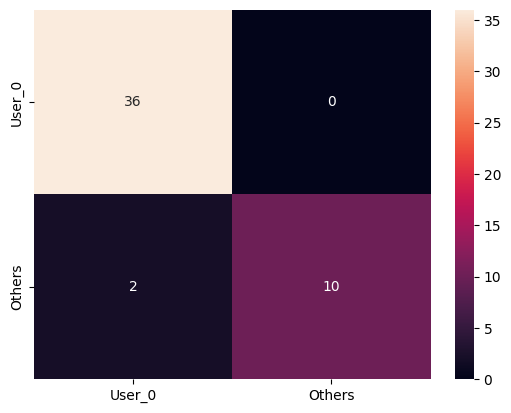

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = (model.predict(x_test) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['User_0', 'Others'], yticklabels=['User_0', 'Others'])

In [24]:
# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open('speaker_recognition.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpfgqfua7a'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 40, 40), dtype=tf.float32, name='keras_tensor_24')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  136452962060816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136452962059280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136452962065232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136452962064848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136452962065808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136452962066576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136452962066000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136452962067152: TensorSpec(shape=(), dtype=tf.resource, name=None)
